# Web_Scraping | Autotrader.uk | Rolls-Royce Pricing Dataset

The code below was used to scrape multiple URLs, create csv files for each link and concat all csvs to get final Rolls_Royce dataset with shape (205,5)

In [ ]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

url = 'https://www.autotrader.co.uk/car-search?sort=relevance&postcode=w1a0ax&radius=200&make=ROLLS-ROYCE&model=PHANTOM&include-delivery-option=on&page=2'
filename = 'autotrader_scrape1'

def create_car_data(url, filename):
  web_page = uReq(url)
  page_html = web_page.read()
  web_page.close()
  page_soup = soup(page_html)

  container = page_soup.findAll('div', {'class':'product-card__inner'})
  
  file = str(filename) + '.csv'
  f = open(file, 'w')
  headers = 'Model,Year,Mileage,Seller_Type,Price\n' 
  f.write(headers)


  for car in container:
    price_t = car.find_all('div', {'class':'product-card-pricing__price'})
    price = (price_t[0].text).replace(',','').replace('£','').strip()
    model_t = car.find_all('h3', {'class':'product-card-details__title'})
    model = model_t[0].text.strip().strip('…')[:19]
    year = car.ul.li.text.strip()[:4]
    mileage = car.ul.li.fetchNextSiblings()[1].text.replace(',','').replace('miles','').strip()
    seller_t = car.find('div', {'class':'product-card-seller__seller-type'})
    if seller_t is None:
      seller_type = 'NA'
    else:
      seller_type = seller_t.text.strip()[:7]

    f.write(model + ',' + year + ',' + mileage + ',' + seller_type + ',' + price + '\n')

  f.close()

create_car_data(url, filename)

In [ ]:
url = 'https://www.autotrader.co.uk/car-search?sort=relevance&postcode=w1a0ax&radius=200&make=ROLLS-ROYCE&model=PHANTOM&include-delivery-option=on&page=8'
filename = 'a8'
create_car_data(url,filename)

In [ ]:
import pandas as pd
auto = pd.read_csv('/content/a8.csv')
auto

In [234]:
link_rollsroyce_dataset = 'https://drive.google.com/file/d/1mpQY1wSqiLkPC4aeCBz2i7rLgN-PX0HH/view?usp=sharing'
link_bentley_dataset = 'https://drive.google.com/file/d/1mPaKcZbbpr5JeGeHlJshBkT5yB5XpiHt/view?usp=sharing'

## Preprocessing, Train-Test split and EDA

In [3]:
%tensorflow_version 2.x

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ensure latest version of tensorflow

rr = pd.read_csv('/content/rolls_royce.csv')
rr.head()

,Unnamed: 0,Model,Year,Mileage,Seller_Type,Price,Brand
0,0,Phantom,2007,38000,Dealer,77990,Rolls-Royce
1,1,Phantom,2006,56500,Individual,69950,Rolls-Royce
2,2,Phantom,2015,6324,Dealer,158950,Rolls-Royce
3,3,Phantom,2009,21000,Dealer,139990,Rolls-Royce
4,4,Phantom,2004,107000,Individual,57500,Rolls-Royce


In [233]:
rr.shape

(209, 7)

**Create Copy of DataFrame**

In [4]:
rr1 = rr.copy()

**Drop Unwanted Columns - Unnamed: 0, Brand**

Use axis=1 to drop entire column

In [5]:
rr1.drop(['Unnamed: 0', 'Brand'], axis=1, inplace=True)

**Basic Summary**

In [6]:
# check for dtypes of columns and Missing Values
rr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Model        209 non-null    object
 1   Year         209 non-null    int64 
 2   Mileage      209 non-null    int64 
 3   Seller_Type  182 non-null    object
 4   Price        209 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 8.3+ KB


**Value_Counts summary for Categorical Columns**

In [7]:
def cat_summary(columns , dataset):
  """ return value_counts summary of categorical columns"""

  for col in columns:
    display(dataset[col].value_counts())
    print('')

cat_summary(columns = ['Model', 'Seller_Type'], dataset=rr1)

Phantom     80
Ghost       72
Dawn        41
Cullinan    16
Name: Model, dtype: int64

Dealer        164
Individual     18
Name: Seller_Type, dtype: int64

**Dealing w/ Missing Values**

Dropping values will result in rows containing that missing value also being dropped.
When dataset is small, this can be less than desirable.

Let's impute with most_frequent values.

In [8]:
rr1['Seller_Type'].iloc[70:75]

70    NaN
71    NaN
72    NaN
73    NaN
74    NaN
Name: Seller_Type, dtype: object

In [9]:
rr1['Seller_Type'].replace(np.nan, 'Dealer', inplace=True)

In [10]:
rr1['Seller_Type'][70:75]

70    Dealer
71    Dealer
72    Dealer
73    Dealer
74    Dealer
Name: Seller_Type, dtype: object

**Summary for Numerical Columns**

In [11]:
num_summary = rr1.describe()
num_summary.pop('Price')
num_summary.pop('Year')
num_summary = num_summary.transpose()

num_summary

,count,mean,std,min,25%,50%,75%,max
Mileage,209.0,25937.923445,26484.848074,63.0,7300.0,16500.0,35000.0,129790.0


**Remove Models before 2000**

In [12]:
rr1['Year'].value_counts().sort_index()

1936     1
1960     1
1961     1
1973     1
2004     4
2005     7
2006     4
2007     8
2008     9
2009     6
2010    15
2011    14
2012    16
2013    10
2014    11
2015    14
2016    10
2017    18
2018    20
2019    24
2020    10
2021     5
Name: Year, dtype: int64

In [13]:
# selecting only those values after year 2004
rr1 = rr1[rr1['Year'] >= 2004]

**Bin Year**

In [14]:
def bin_feature(feature, label_name, column_name, df, bins):
  """creates bins for feature with label names and add new column to dataframe"""
  df[column_name] = pd.qcut(df[feature], q=bins, labels=label_name)

In [15]:
bin_feature(
    feature='Year', 
    label_name=['2004_2008', '2009_2011', '2012_2014', '2015_2017', '2018_2019', '2020_2021'], 
    column_name='Year_Binned',
    df=rr1,
    bins=6
    )

In [16]:
rr1.head()

,Model,Year,Mileage,Seller_Type,Price,Year_Binned
0,Phantom,2007,38000,Dealer,77990,2004_2008
1,Phantom,2006,56500,Individual,69950,2004_2008
2,Phantom,2015,6324,Dealer,158950,2015_2017
3,Phantom,2009,21000,Dealer,139990,2004_2008
4,Phantom,2004,107000,Individual,57500,2004_2008


**EDA - Inspect Data**

our visual inspection would be better suited after we removed 4 car models older than 2004.

**Pair Plot for Multi_Variate Analysis**

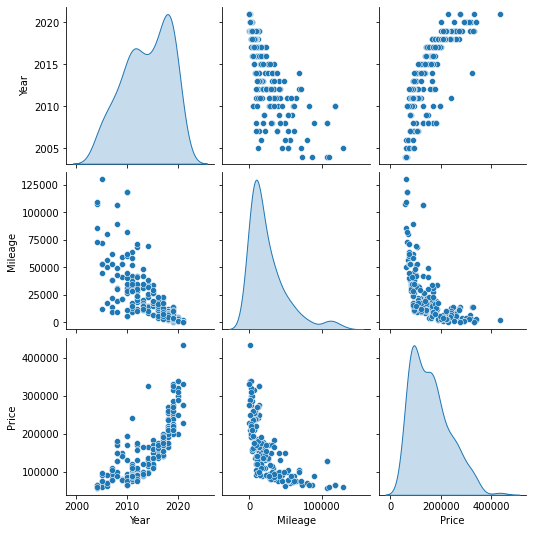

In [17]:
import matplotlib.pyplot as plt

sns.pairplot(rr1, diag_kind='kde')
plt.show()

**Bar Plots for Model_Price | YearBinned_Price | SellerType_Price | Model_Mileage | YearBinned_Mileage**

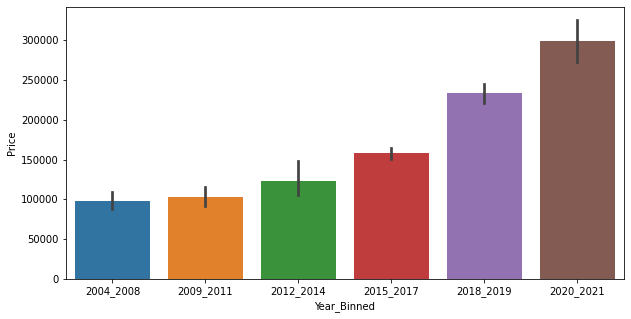

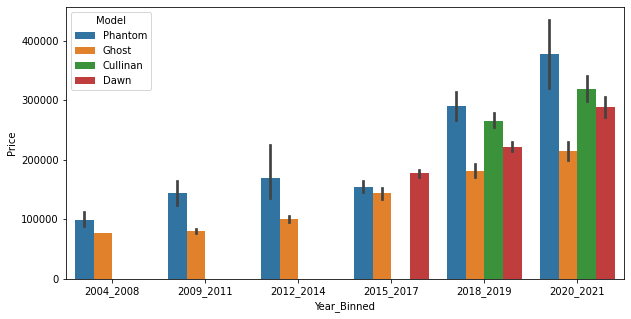

In [18]:
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))

plt.figure(figsize=(10,5))
sns.barplot(x=rr1['Year_Binned'], y=rr1['Price'])
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=rr1['Year_Binned'], y=rr1['Price'], hue=rr1['Model'])
plt.show()

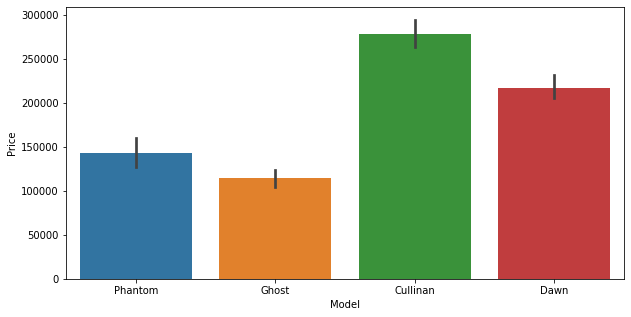

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=rr1['Model'], y=rr1['Price'], ax=ax)
plt.show()

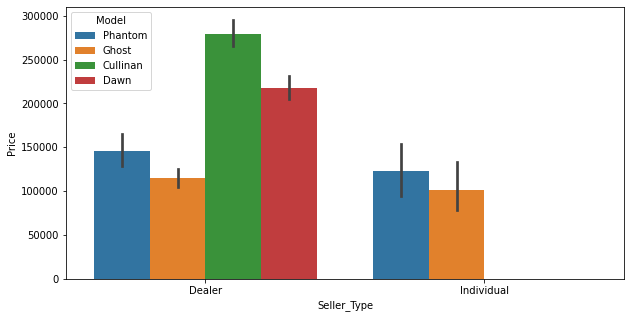

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=rr1['Seller_Type'], y=rr1['Price'], ax=ax, hue=rr1['Model'])
plt.show()

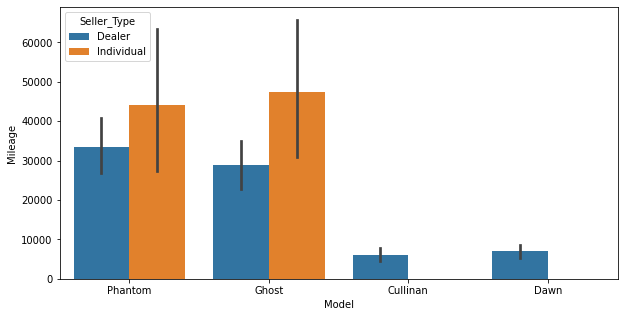

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=rr1['Model'], y=rr1['Mileage'], hue=rr1['Seller_Type'], ax=ax)
plt.show()

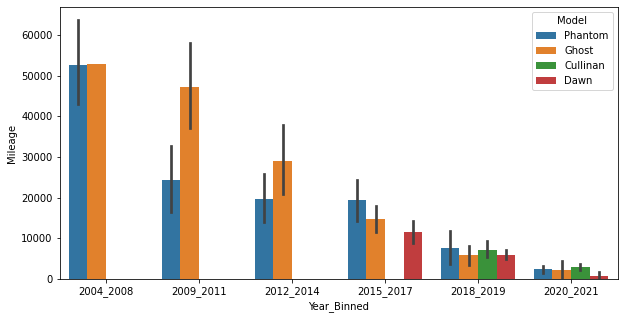

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x=rr1['Year_Binned'], y=rr1['Mileage'], hue=rr1['Model'])
plt.show()

**Univariate Analysis - Histograms of Price, Mileage, Year**

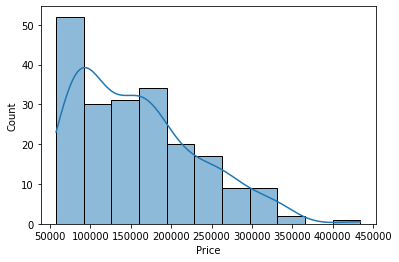

In [23]:
sns.histplot(rr1['Price'], kde=True)
plt.show()

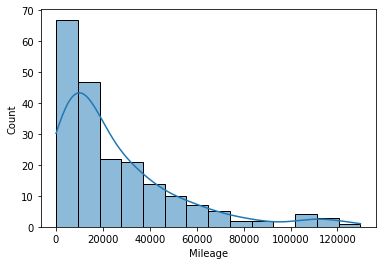

In [24]:
sns.histplot(rr1['Mileage'], kde=True)
plt.show()

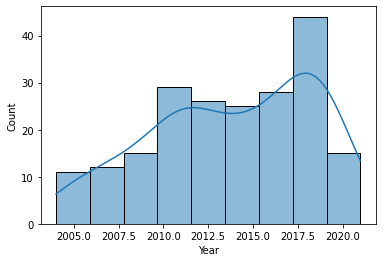

In [25]:
sns.histplot(rr1['Year'], kde=True)
plt.show()

**Manual One-Hot Encoding**

In [26]:
# Auto Encoding using pandas.get_dummies(df)

pd.get_dummies(rr1).head()

,Year,Mileage,Price,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021
0,2007,38000,77990,0,0,0,1,1,0,1,0,0,0,0,0
1,2006,56500,69950,0,0,0,1,0,1,1,0,0,0,0,0
2,2015,6324,158950,0,0,0,1,1,0,0,0,0,1,0,0
3,2009,21000,139990,0,0,0,1,1,0,1,0,0,0,0,0
4,2004,107000,57500,0,0,0,1,0,1,1,0,0,0,0,0


In [27]:
# manual encoding

model = rr1['Model']

rr1['Phantom'] = (model=='Phantom')*1
rr1['Ghost'] = (model=='Ghost')*1
rr1['Dawn'] = (model=='Dawn')*1
rr1['Cullinan'] = (model=='Cullinan')*1

rr1.tail()

,Model,Year,Mileage,Seller_Type,Price,Year_Binned,Phantom,Ghost,Dawn,Cullinan
203,Dawn,2019,4000,Dealer,208950,2018_2019,0,0,1,0
204,Dawn,2016,22911,Dealer,169911,2015_2017,0,0,1,0
205,Dawn,2017,7000,Dealer,175000,2015_2017,0,0,1,0
207,Dawn,2020,700,Dealer,249990,2020_2021,0,0,1,0
208,Dawn,2021,101,Dealer,274950,2020_2021,0,0,1,0


In [28]:
# drop manually created columns
rr1.drop(['Phantom', 'Dawn', 'Ghost', 'Cullinan'], axis=1, inplace=True)

In [29]:
# we will use auto encoding via pd.get_dummies(df) since we have Model, Year_Binned, and Seller_Type to convert to one-hot
rr2 = pd.get_dummies(rr1, drop_first=False)
rr2.head()

,Year,Mileage,Price,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021
0,2007,38000,77990,0,0,0,1,1,0,1,0,0,0,0,0
1,2006,56500,69950,0,0,0,1,0,1,1,0,0,0,0,0
2,2015,6324,158950,0,0,0,1,1,0,0,0,0,1,0,0
3,2009,21000,139990,0,0,0,1,1,0,1,0,0,0,0,0
4,2004,107000,57500,0,0,0,1,0,1,1,0,0,0,0,0


In [30]:
rr2.shape

(205, 15)

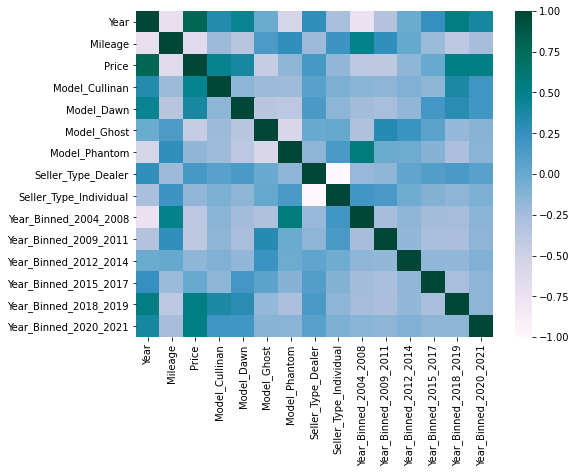

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(rr2.corr(), ax=ax,cmap='PuBuGn')
plt.show()

**Split Data into Train & Test | Feature & Labels**

Random Shuffle to mimic stratify due to Model Class imbalance

In [32]:
rr2 = rr2.reindex(np.random.permutation(rr2.index))

In [33]:
rr2.head()

,Year,Mileage,Price,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021
202,2019,3200,219995,0,1,0,0,1,0,0,0,0,0,1,0
116,2013,17500,87500,0,0,1,0,1,0,0,0,1,0,0,0
104,2017,17494,139890,0,0,1,0,1,0,0,0,0,1,0,0
46,2007,14000,93000,0,0,0,1,1,0,1,0,0,0,0,0
26,2004,73000,63950,0,0,0,1,0,1,1,0,0,0,0,0


In [34]:
# split data into train and test
rr2_train = rr2.sample(frac=0.75, random_state=0)
rr2_test = rr2.drop(rr2_train.index)

In [35]:
# split Data into Feature and Label

train_label = rr2_train.pop('Price')
test_label = rr2_test.pop('Price')

**Normalize Mileage**

In [36]:
num_summary

,count,mean,std,min,25%,50%,75%,max
Mileage,209.0,25937.923445,26484.848074,63.0,7300.0,16500.0,35000.0,129790.0


In [37]:
def normalize(df):
  return (df['Mileage'] - df['Mileage'].mean())/df['Mileage'].std()

rr2_train['Mileage_Norm'] = normalize(rr2_train)
rr2_test['Mileage_Norm'] = normalize(rr2_test)

In [38]:
rr2_train.head()

,Year,Mileage,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021,Mileage_Norm
90,2012,24000,0,0,1,0,1,0,0,1,0,0,0,0,-0.078165
153,2019,8000,1,0,0,0,1,0,0,0,0,0,1,0,-0.650551
113,2012,34509,0,0,1,0,1,0,0,1,0,0,0,0,0.297786
149,2018,2100,0,0,1,0,1,0,0,0,0,0,1,0,-0.861618
130,2013,15218,0,0,1,0,1,0,0,0,1,0,0,0,-0.392333


In [39]:
rr2_test.head()

,Year,Mileage,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021,Mileage_Norm
157,2018,8000,1,0,0,0,1,0,0,0,0,0,1,0,-0.715941
140,2012,30000,0,0,1,0,1,0,0,1,0,0,0,0,0.287484
128,2012,41000,0,0,1,0,0,1,0,1,0,0,0,0,0.789197
137,2015,14800,0,0,1,0,1,0,0,0,0,1,0,0,-0.405792
57,2007,22000,0,0,0,1,0,1,1,0,0,0,0,0,-0.077398


In [40]:
# train-test arrays

train_features = rr2_train.values
train_labels = train_label.values

test_features = rr2_test.values
test_labels = test_label.values

## **Simple Model**

1.   Use of Estimator API - {RMSE : 143409}
2.   Sequential - {RMSE : 56963}
3.   Functional API - {RMSE : }


### **Simple Model in TensorFLow using Estimator APIs**

In [41]:
def input_fn():
  features = {'Year': rr2_train['Year'],
              'Mileage': rr2_train['Mileage']}
  labels = train_label

  return features, labels

In [42]:
# use only Year and Mileage as features

year = tf.feature_column.numeric_column('Year')
mileage = tf.feature_column.numeric_column('Mileage')

feature_list = [year, mileage]

model0 = tf.estimator.DNNRegressor(feature_columns=feature_list, hidden_units=[450,250])

model0.train(input_fn, steps=300)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnr21mpcl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initiali

In [43]:
def input_fn():
  features = {'Year': rr2_test['Year'],
              'Mileage':rr2_test['Mileage']}
  labels = test_label
  return features, labels
  
model0.evaluate(input_fn, steps=300)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-22T07:39:30Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnr21mpcl/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [30/300]
INFO:tensorflow:Evaluation [60/300]
INFO:tensorflow:Evaluation [90/300]
INFO:tensorflow:Evaluation [120/300]
INFO:tensorflow:Evaluation [150/300]
INFO:tensorflow:Evaluation [180/300]
INFO:tensorflow:Evaluation [210/300]
INFO:tensorflow:Evaluation [240/300]
INFO:tensorflow:Evaluation [270/300]
INFO:tensorflow:Evaluation [300/300]
INFO:tensorflow:Inference Time : 0.44076s
INFO:tensorflow:Finished evaluation at 2021-03-22-07:39:31
INFO:tensorflow:Saving dict for global step 300: average_loss = 19879784000.0, global_step = 300, label/mean = 154031.56, loss = 19879905000.0, prediction/mean = 53526.184
INFO:tensorflow:Saving 'checkpoin

{'average_loss': 19879784000.0,
 'global_step': 300,
 'label/mean': 154031.56,
 'loss': 19879905000.0,
 'prediction/mean': 53526.184}

In [44]:
rmse_estimator = np.sqrt(20566233000)
rmse_estimator

# the Estimator API didn't perform well at all.

143409.31978082875

## **Using Sequential Modeling in Keras and TensorFlow**

In [45]:
def create_model(n_cols, learning_rate):
  """ creates a Sequential model in tf.keras """

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(250, activation='relu', input_shape=(n_cols,)))
  model.add(tf.keras.layers.Dense(250, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  optimizer = tf.keras.optimizers.RMSprop(learning_rate)
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

  return model

**Implementing Callbacks in Keras - EarlyStopping**

EarlyStopping allows us to stop training when a certain metric doesn't seem to improve over the course of training. This saves computation power and allows us to reduce overfitting. 

In [46]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=10, monitor='val_mae')

n_cols = train_features.shape[1]
learning_rate = 0.01

model = create_model(n_cols, learning_rate)

EPOCHS = 200
history = model.fit(train_features, train_labels, epochs=EPOCHS, batch_size=12, validation_data=(test_features, test_labels), callbacks=[early_stopping])

Epoch 1/200
13/13 [==============================] - 1s 22ms/step - loss: 26984553618.2857 - mse: 26984553618.2857 - mae: 134082.7288 - val_loss: 20022833152.0000 - val_mse: 20022833152.0000 - val_mae: 129343.4688
Epoch 2/200
13/13 [==============================] - 0s 6ms/step - loss: 14703707721.1429 - mse: 14703707721.1429 - mae: 95389.2444 - val_loss: 2407413504.0000 - val_mse: 2407413504.0000 - val_mae: 40617.8711
Epoch 3/200
13/13 [==============================] - 0s 6ms/step - loss: 2882907099.4286 - mse: 2882907099.4286 - mae: 43829.5801 - val_loss: 2411618560.0000 - val_mse: 2411618560.0000 - val_mae: 36998.2852
Epoch 4/200
13/13 [==============================] - 0s 5ms/step - loss: 3753109357.7143 - mse: 3753109595.4286 - mae: 49329.6362 - val_loss: 2970112000.0000 - val_mse: 2970112000.0000 - val_mae: 43825.5039
Epoch 5/200
13/13 [==============================] - 0s 5ms/step - loss: 3046860562.2857 - mse: 3046860562.2857 - mae: 45227.2877 - val_loss: 4460219392.0000 - val

**Plot loss curve**

In [47]:
hist = pd.DataFrame(history.history)
epochs = history.epoch
hist.head()

,loss,mse,mae,val_loss,val_mse,val_mae
0,2.291805e+10,2.291805e+10,123131.367188,2.002283e+10,2.002283e+10,129343.468750
1,8.676109e+09,8.676109e+09,68922.789062,2.407414e+09,2.407414e+09,40617.871094
2,3.683217e+09,3.683217e+09,48647.027344,2.411619e+09,2.411619e+09,36998.285156
3,3.668694e+09,3.668694e+09,48551.511719,2.970112e+09,2.970112e+09,43825.503906
4,2.820906e+09,2.820906e+09,42472.812500,4.460219e+09,4.460219e+09,55863.101562


In [48]:
history.history.keys()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])

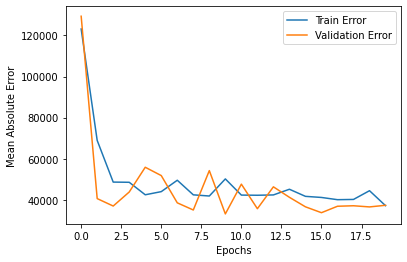

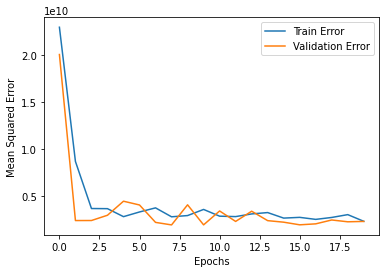

In [49]:
import matplotlib.pyplot as plt

def plot_history(history):
  
  hist = pd.DataFrame(history.history)
  epochs = history.epoch

  plt.figure()
  plt.plot(epochs, hist['mae'], label='Train Error')
  plt.plot(epochs, hist['val_mae'], label='Validation Error')
  plt.xlabel('Epochs')
  plt.ylabel('Mean Absolute Error')
  plt.legend()
  

  plt.figure()
  plt.plot(epochs, hist['mse'], label='Train Error')
  plt.plot(epochs, hist['val_mse'], label='Validation Error')
  plt.xlabel('Epochs')
  plt.ylabel('Mean Squared Error')
  plt.legend()

plot_history(history)

**Model Evaluation**

In [50]:
pred = model.predict(test_features)

print(pred - test_labels)

[[-6.75884219e+04  1.07421578e+05  1.00411578e+05 ...  4.46157812e+03
  -3.75884219e+04  3.44215781e+04]
 [-1.66983492e+05  8.02650781e+03  1.01650781e+03 ... -9.49334922e+04
  -1.36983492e+05 -6.49734922e+04]
 [-1.88662781e+05 -1.36527812e+04 -2.06627812e+04 ... -1.16612781e+05
  -1.58662781e+05 -8.66527812e+04]
 ...
 [-1.75672508e+05 -6.62507812e+02 -7.67250781e+03 ... -1.03622508e+05
  -1.45672508e+05 -7.36625078e+04]
 [-8.33125000e+01  1.74926688e+05  1.67916688e+05 ...  7.19666875e+04
   2.99166875e+04  1.01926688e+05]
 [-1.46735977e+05  2.82740234e+04  2.12640234e+04 ... -7.46859766e+04
  -1.16735977e+05 -4.47259766e+04]]


In [51]:
test_rmse = model.evaluate(test_features, test_labels)
print(test_rmse[2])

2/2 [==============================] - 0s 4ms/step - loss: 2315409152.0000 - mse: 2315409152.0000 - mae: 37363.7656
37363.765625


**Implementing Callbacks in Keras - ModelCheckpoint**

In [52]:
from keras.callbacks import ModelCheckpoint

model_save = ModelCheckpoint('rr_model.hdf5', 
                             save_best_only=True, 
                             monitor='val_mae')

n_cols = train_features.shape[1]
learning_rate = 0.01

model = create_model(n_cols, learning_rate)

epochs = 200
history = model.fit(train_features, train_labels, epochs=epochs, batch_size=12, validation_data=(test_features, test_labels), callbacks=[model_save])

Epoch 1/200
13/13 [==============================] - 1s 17ms/step - loss: 31380398957.7143 - mse: 31380398957.7143 - mae: 135805.2684 - val_loss: 15322856448.0000 - val_mse: 15322856448.0000 - val_mae: 104417.9922
Epoch 2/200
13/13 [==============================] - 0s 5ms/step - loss: 14606366134.8571 - mse: 14606366208.0000 - mae: 95262.6814 - val_loss: 3616603904.0000 - val_mse: 3616603904.0000 - val_mae: 48253.6523
Epoch 3/200
13/13 [==============================] - 0s 6ms/step - loss: 5142924598.8571 - mse: 5142924598.8571 - mae: 59952.9322 - val_loss: 2037630848.0000 - val_mse: 2037630848.0000 - val_mae: 35058.6445
Epoch 4/200
13/13 [==============================] - 0s 5ms/step - loss: 4252882925.7143 - mse: 4252882925.7143 - mae: 52790.9445 - val_loss: 4355518464.0000 - val_mse: 4355518464.0000 - val_mae: 53434.0430
Epoch 5/200
13/13 [==============================] - 0s 5ms/step - loss: 3855310573.7143 - mse: 3855310573.7143 - mae: 46247.6211 - val_loss: 6266976768.0000 - val

**Loading a Checkpoint Model**

In [53]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(250, activation='relu', input_shape=(n_cols,)))
model.add(tf.keras.layers.Dense(250, activation='relu'))
model.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.RMSprop(learning_rate)

# load weights of best_model learned from ModelCheckpoint
model.load_weights('rr_model.hdf5')

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

score = model.evaluate(test_features, test_labels, verbose=0)
print('%s: %.2f%%' % (model.metrics_names[2], score[2]))

mae: 32188.06%


**Plot Loss curve for Model trained with ModelCheckpoint callback**

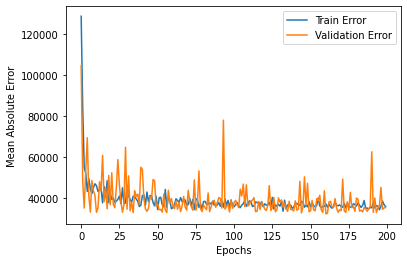

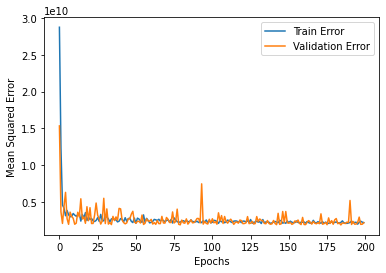

In [54]:
plot_history(history)

**Plot to evaluate if Model Needs more Data**

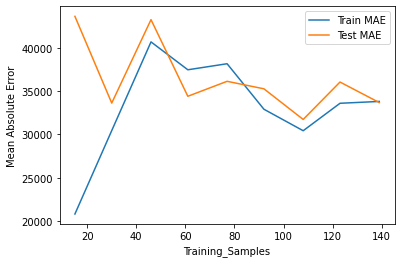

In [55]:
def plot_sample_vs_metrics(model):
  """Create line plots of train and test metrics per given sample and helps us identify if model needs more data"""

  # init_weights = model.get_weights()
  train_maes = []
  test_maes = []

  train_sizes = [15,30,46,61,77,92,108,123,139]

  from sklearn.model_selection import train_test_split
  
  for train_size in train_sizes:
    X_train_frac, _ , y_train_frac, _ = train_test_split(train_features, train_labels, train_size=train_size)

    # model.set_weights(init_weights)
    early_stopping = EarlyStopping(monitor='mae', patience=5)

    model.fit(X_train_frac, y_train_frac, epochs=100, callbacks=[early_stopping], verbose=0)

    train_mae = model.evaluate(X_train_frac, y_train_frac, verbose=0)[2]
    train_maes.append(train_mae)

    test_mae = model.evaluate(test_features, test_labels, verbose=0)[2]
    test_maes.append(test_mae)

  training_samples = [15,30,46,61,77,92,108,123,139]

  plt.figure()
  plt.plot(training_samples, train_maes, label='Train MAE')
  plt.plot(training_samples, test_maes, label='Test MAE')
  plt.xlabel('Training_Samples')
  plt.ylabel('Mean Absolute Error')
  plt.legend()
  plt.show()

plot_sample_vs_metrics(model)

**Comparing Activation Functions**

In [56]:
%tensorflow_version 2.x
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

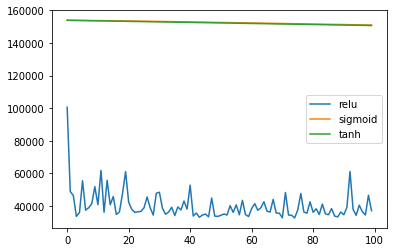

In [57]:
def create_model_act_func(act_func):
  """creates keras Sequential model for given activation function - Sigmoid, Relu, tanh, leaky_relu"""

  model = Sequential()
  model.add(Dense(250, input_shape=(n_cols,), activation=act_func))
  model.add(Dense(250, activation=act_func))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.RMSprop(learning_rate)
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

  return model

activations = ['relu', 'sigmoid', 'tanh']

activation_results = {}

for func in activations:
  model = create_model_act_func(act_func=func)
  history = model.fit(train_features, train_labels, validation_data=(test_features, test_labels), epochs=100, batch_size=12, verbose=0)

  activation_results[func] = history

val_loss_per_func = {key: value.history['val_mae'] for key, value in activation_results.items()}

val_loss_curve = pd.DataFrame(val_loss_per_func)

# val_loss_curve.plot(title='Loss per Activation Function')
plt.figure()
plt.plot(val_loss_curve['relu'], label='relu')
plt.plot(val_loss_curve['sigmoid'], label='sigmoid')
plt.plot(val_loss_curve['tanh'], label='tanh')
plt.legend()
plt.show()

**HyperParameter Tuning - Using Sklearn RandomizedSearch CV**

In [58]:
# def create_model_sk(optimizer='adam', activation='relu'):
#   """Creates a model to be used for HyperParameter Tuning"""

#   model = Sequential()
#   model.add(Dense(250, input_shape=(n_cols,), activation=activation))
#   model.add(Dense(250, activation=activation))
#   model.add(Dense(1))
  
#   model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

#   return model


**Performing Cross_Validation**

In [59]:
# from sklearn.model_selection import cross_val_score

# kfold = cross_val_score(model_1, train_features, train_labels, cv=5)
# print(kfold)

In [60]:
# from keras.wrappers.scikit_learn import KerasRegressor

# param_dict = {'optimizer' : ['adam', 'sgd']}

# from sklearn.model_selection import RandomizedSearchCV
# model_1 = KerasRegressor(build_fn=create_model_sk, epochs=50, batch_size=12)


# random_search = RandomizedSearchCV(model_1, param_distributions=param_dict, cv=3)

# random_search_result = random_search.fit(train_features, train_labels, callbacks=[EarlyStopping(monitor='mae', patience=3)])

# print('Best MAE:{} using {}'.format(random_search_result.best_score_, random_search_result.best_params_))

**Plot TestLabels and Predictions**

In [61]:
# Running this model as last model uses tanh as activation function and throws of Plot of Predictions and Errors

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(250, activation='relu', input_shape=(n_cols,)))
model.add(tf.keras.layers.Dense(250, activation='relu'))
model.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.RMSprop(learning_rate)

# load weights of best_model learned from ModelCheckpoint
model.load_weights('rr_model.hdf5')

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

score = model.evaluate(test_features, test_labels, verbose=0)

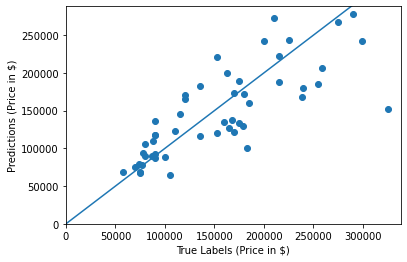

In [62]:
test_predictions = model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Labels (Price in $)')
plt.ylabel('Predictions (Price in $)')
# plt.axis('equal')
# plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 400000], [-100, 400000])


# a perfect prediction would entail that all these points be on the line

**Error Distribution**

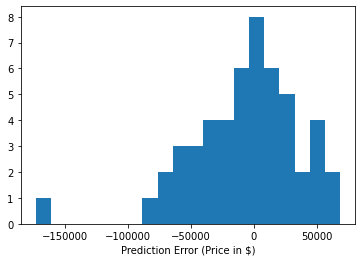

In [63]:
error = test_predictions - test_labels
plt.hist(error, bins=20)
plt.xlabel('Prediction Error (Price in $)')
plt.show()

# our error is approximately gaussian distributed and it's centered around 0

**Comparing Train vs Test results**

In [64]:
train_mae = model.evaluate(train_features, train_labels, batch_size=12, verbose=0)

print('Train MAE: {}'.format(train_mae[2]))

Train MAE: 33156.078125


In [65]:
test_mae = model.evaluate(test_features, test_labels, batch_size=12, verbose=0)
print('Test MAE: {}'.format(test_mae[2]))

Test MAE: 32188.05859375


In [66]:
print('Test RMSE: {:.3f}'.format(np.sqrt(test_mae[1])))
print('Train RMSE: {:.3f}'.format(np.sqrt(train_mae[1])))

Test RMSE: 43462.914
Train RMSE: 45065.022


### Analysis of Sequential Modelling

**Analysis of Sequential Model**

Through our modelling, we achieved a validation mae which is similar to train mae, and on further evaluation both values are actually close. 

However, our test_rmse is significantly higher than train_rmse signalling overfitting. To reduce overfitting, here are some remedial measures: 

*Remedies:*
1.   Remove Year and Mileage Feature as they are available in bucketed_form
2.   Reduce Nodes in Hidden Layer, reduce learning_rate, increase batch_size and reduce epochs.
3.   Introduce Cross_Features
4.   Introduce Regularization in the model


### Cross_Features

**Cross Products of Features**

In [67]:
rr2_train.columns

Index(['Year', 'Mileage', 'Model_Cullinan', 'Model_Dawn', 'Model_Ghost',
       'Model_Phantom', 'Seller_Type_Dealer', 'Seller_Type_Individual',
       'Year_Binned_2004_2008', 'Year_Binned_2009_2011',
       'Year_Binned_2012_2014', 'Year_Binned_2015_2017',
       'Year_Binned_2018_2019', 'Year_Binned_2020_2021', 'Mileage_Norm'],
      dtype='object')

In [68]:
# create function to create_model with feature_layers
def create_model_cross(my_learning_rate, feature_layer, n_cols):
  """creates a model with feature_layers """

  model = Sequential()
  model.add(feature_layer)
  model.add(Dense(128,input_shape=(n_cols,), activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(my_learning_rate), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

# create function to train_model
def train_model(model, features, labels, epochs, batch_size):
  history = model.fit(x=features, y=labels, 
                      batch_size=batch_size, epochs=epochs, 
                      verbose=1, 
                      callbacks=[EarlyStopping(monitor='val_root_mean_squared_error', patience=20)], 
                      validation_split=0.2)

  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  train_rmse = hist['root_mean_squared_error']
  val_rmse = hist['val_root_mean_squared_error']

  return epochs, train_rmse, val_rmse

# create function to plot loss_curve
def plot_loss_curve(epochs, train_mse, val_mse):
  plt.plot(epochs, train_rmse, label='Train')
  plt.plot(epochs, val_rmse, label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('RMSE')
  plt.legend()
  plt.show()


**Year and Mileage as Features- Non Normalized**

In [69]:
# create feature_columns from tf.feature_columns

feature_columns = []
year = tf.feature_column.numeric_column('Year', dtype=tf.int32)
feature_columns.append(year)

mileage = tf.feature_column.numeric_column('Mileage', dtype=tf.int32)
feature_columns.append(mileage)

from keras import layers
feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/11 [=>............................] - ETA: 5s - loss: 25471492096.0000 - root_mean_squared_error: 159597.9062WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Year': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float32>, 'Mileage': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>}
Consider rewriting this model with the Functional API.
11/11 [==============================] - 1s 23ms/step - loss: 26619411626.6667 - root_mean_squared_error: 163109.3867 - val_loss: 25388634112.0000 - val_root_mean_squared_error: 159338.1094
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 19046820864.0000 - root_mean_squared_error: 137929.7676 - val_loss: 21349292032.0000 - val_root_mean_squared_error: 146113.9688
Epoch 3/100
11/11 [==============================] - 0s

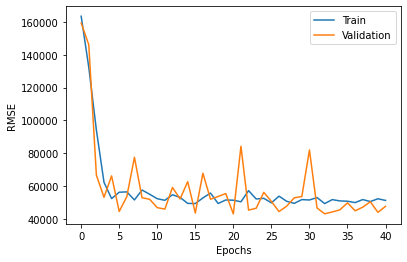

In [70]:
features_dict = {'Year': train_features[:,0], 'Mileage': train_features[:,1]}
test_features_dict = {'Year': test_features[:,0], 'Mileage':test_features[:,1]}

n_cols = len(features_dict)
model = create_model_cross(my_learning_rate=0.01, feature_layer=feature_layer, n_cols=n_cols)

epochs, train_rmse, val_rmse = train_model(model, features_dict, train_labels, epochs=100, batch_size=12)

plot_loss_curve(epochs, train_rmse, val_rmse)

In [71]:
batch_size = 12
test_rmse_Year_Mileage = model.evaluate(test_features_dict, test_labels, batch_size=batch_size, verbose=0)[1]
print('Test RMSE with Year and Mileage as Features: {:.3f}'.format(test_rmse_Year_Mileage))

Test RMSE with Year and Mileage as Features: 45207.551


**Use Feature Cross with Year_Binned and Mileage_Norm**

In [72]:
# boundaries = [2004, 2008, 2011, 2014, 2017, 2020]

In [73]:
rr3 = rr2_train.copy()

rr3['2015_2017_Mileage_Norm'] = rr3['Year_Binned_2015_2017']*rr3['Mileage_Norm']
rr3['2004_2008_Mileage_Norm'] = rr3['Year_Binned_2004_2008']*rr3['Mileage_Norm']
rr3['2009_2011_Mileage_Norm'] = rr3['Year_Binned_2009_2011']*rr3['Mileage_Norm']
rr3['2012_2014_Mileage_Norm'] = rr3['Year_Binned_2012_2014']*rr3['Mileage_Norm']
rr3['2018_2019_Mileage_Norm'] = rr3['Year_Binned_2018_2019']*rr3['Mileage_Norm']
rr3['2020_2021_Mileage_Norm'] = rr3['Year_Binned_2020_2021']*rr3['Mileage_Norm']

In [74]:
rr3_test = rr2_test.copy()

rr3_test['2015_2017_Mileage_Norm'] = rr3_test['Year_Binned_2015_2017']*rr3_test['Mileage_Norm']
rr3_test['2004_2008_Mileage_Norm'] = rr3_test['Year_Binned_2004_2008']*rr3_test['Mileage_Norm']
rr3_test['2009_2011_Mileage_Norm'] = rr3_test['Year_Binned_2009_2011']*rr3_test['Mileage_Norm']
rr3_test['2012_2014_Mileage_Norm'] = rr3_test['Year_Binned_2012_2014']*rr3_test['Mileage_Norm']
rr3_test['2018_2019_Mileage_Norm'] = rr3_test['Year_Binned_2018_2019']*rr3_test['Mileage_Norm']
rr3_test['2020_2021_Mileage_Norm'] = rr3_test['Year_Binned_2020_2021']*rr3_test['Mileage_Norm']

In [75]:
rr3_test['04_08_MilNorm_Cullinan'] = rr3_test['2004_2008_Mileage_Norm']*rr3_test['Model_Cullinan'] 
rr3_test['09_11_MilNorm_Cullinan'] = rr3_test['2009_2011_Mileage_Norm']*rr3_test['Model_Cullinan']
rr3_test['12_14_MilNorm_Cullinan'] = rr3_test['2012_2014_Mileage_Norm']*rr3_test['Model_Cullinan']
rr3_test['15_17_MilNorm_Cullinan'] = rr3_test['2015_2017_Mileage_Norm']*rr3_test['Model_Cullinan']
rr3_test['18_19_MilNorm_Cullinan'] = rr3_test['2018_2019_Mileage_Norm']*rr3_test['Model_Cullinan']
rr3_test['20_21_MilNorm_Cullinan'] = rr3_test['2020_2021_Mileage_Norm']*rr3_test['Model_Cullinan']

rr3_test['04_08_MilNorm_Ghost'] = rr3_test['2004_2008_Mileage_Norm']*rr3_test['Model_Ghost'] 
rr3_test['09_11_MilNorm_Ghost'] = rr3_test['2009_2011_Mileage_Norm']*rr3_test['Model_Ghost']
rr3_test['12_14_MilNorm_Ghost'] = rr3_test['2012_2014_Mileage_Norm']*rr3_test['Model_Ghost']
rr3_test['15_17_MilNorm_Ghost'] = rr3_test['2015_2017_Mileage_Norm']*rr3_test['Model_Ghost']
rr3_test['18_19_MilNorm_Ghost'] = rr3_test['2018_2019_Mileage_Norm']*rr3_test['Model_Ghost']
rr3_test['20_21_MilNorm_Ghost'] = rr3_test['2020_2021_Mileage_Norm']*rr3_test['Model_Ghost']

rr3_test['04_08_MilNorm_Dawn'] = rr3_test['2004_2008_Mileage_Norm']*rr3_test['Model_Dawn'] 
rr3_test['09_11_MilNorm_Dawn'] = rr3_test['2009_2011_Mileage_Norm']*rr3_test['Model_Dawn']
rr3_test['12_14_MilNorm_Dawn'] = rr3_test['2012_2014_Mileage_Norm']*rr3_test['Model_Dawn']
rr3_test['15_17_MilNorm_Dawn'] = rr3_test['2015_2017_Mileage_Norm']*rr3_test['Model_Dawn']
rr3_test['18_19_MilNorm_Dawn'] = rr3_test['2018_2019_Mileage_Norm']*rr3_test['Model_Dawn']
rr3_test['20_21_MilNorm_Dawn'] = rr3_test['2020_2021_Mileage_Norm']*rr3_test['Model_Dawn']

rr3_test['04_08_MilNorm_Phantom'] = rr3_test['2004_2008_Mileage_Norm']*rr3_test['Model_Phantom'] 
rr3_test['09_11_MilNorm_Phantom'] = rr3_test['2009_2011_Mileage_Norm']*rr3_test['Model_Phantom']
rr3_test['12_14_MilNorm_Phantom'] = rr3_test['2012_2014_Mileage_Norm']*rr3_test['Model_Phantom']
rr3_test['15_17_MilNorm_Phantom'] = rr3_test['2015_2017_Mileage_Norm']*rr3_test['Model_Phantom']
rr3_test['18_19_MilNorm_Phantom'] = rr3_test['2018_2019_Mileage_Norm']*rr3_test['Model_Phantom']
rr3_test['20_21_MilNorm_Phantom'] = rr3_test['2020_2021_Mileage_Norm']*rr3_test['Model_Phantom']

In [76]:
rr3_test.shape

(51, 45)

In [77]:
# create feature_columns from tf.feature_columns

feature_columns = []
Mileage2015_17 = tf.feature_column.numeric_column('2015_2017_Mileage_Norm')
feature_columns.append(Mileage2015_17)

Mileage2004_08 = tf.feature_column.numeric_column('2004_2008_Mileage_Norm')
feature_columns.append(Mileage2004_08)

Mileage2009_11 = tf.feature_column.numeric_column('2009_2011_Mileage_Norm')
feature_columns.append(Mileage2009_11)

Mileage2012_14 = tf.feature_column.numeric_column('2012_2014_Mileage_Norm')
feature_columns.append(Mileage2012_14)

Mileage2018_19 = tf.feature_column.numeric_column('2018_2019_Mileage_Norm')
feature_columns.append(Mileage2018_19)

Mileage2020_21 = tf.feature_column.numeric_column('2020_2021_Mileage_Norm')
feature_columns.append(Mileage2020_21)

from keras import layers
feature_layer = layers.DenseFeatures(feature_columns)

In [78]:
# rr3.values[:, 15:21]

In [79]:
# rr3.iloc[:, 16].values

Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/11 [=>............................] - ETA: 5s - loss: 22240745472.0000 - root_mean_squared_error: 149133.3125WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'2004_2008_Mileage_Norm': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, '2009_2011_Mileage_Norm': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float32>, '2012_2014_Mileage_Norm': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float32>, '2015_2017_Mileage_Norm': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float32>, '2018_2019_Mileage_Norm': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float32>, '2020_2021_Mileage_Norm': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float32>}
Consider rewriting this model with the Functional API.
11/11 [==============================] - 1s 27ms/step - loss: 3015210

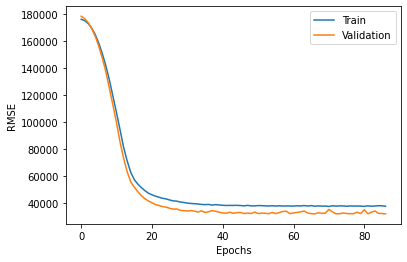

In [80]:
epochs = 100
learning_rate = 0.01
batch_size = 12


features_dict = {
    '2004_2008_Mileage_Norm' : rr3.iloc[:,16].values,
    '2009_2011_Mileage_Norm' : rr3.iloc[:,17].values,
    '2012_2014_Mileage_Norm' : rr3.iloc[:,18].values,
    '2015_2017_Mileage_Norm' : rr3.iloc[:,15].values,
    '2018_2019_Mileage_Norm' : rr3.iloc[:,19].values,
    '2020_2021_Mileage_Norm' : rr3.iloc[:,20].values
}

test_features_dict = {
    '2004_2008_Mileage_Norm' : rr3_test.iloc[:,16].values,
    '2009_2011_Mileage_Norm' : rr3_test.iloc[:,17].values,
    '2012_2014_Mileage_Norm' : rr3_test.iloc[:,18].values,
    '2015_2017_Mileage_Norm' : rr3_test.iloc[:,15].values,
    '2018_2019_Mileage_Norm' : rr3_test.iloc[:,19].values,
    '2020_2021_Mileage_Norm' : rr3_test.iloc[:,20].values
}

n_cols = len(features_dict)

model = create_model_cross(0.01, feature_layer, n_cols=n_cols)

epochs, train_rmse, val_rmse = train_model(model, features_dict, train_labels, epochs=epochs, batch_size=batch_size)

plot_loss_curve(epochs, train_rmse, val_rmse)

In [81]:
test_rmse_cross_YearBinned_MileageNorm = model.evaluate(test_features_dict, test_labels, batch_size=batch_size, verbose=0)[1]
print('Test RMSE with CrossFeature of YearBinned and MileageNormalize: {:.3f}'.format(test_rmse_cross_YearBinned_MileageNorm))

Test RMSE with CrossFeature of YearBinned and MileageNormalize: 45257.289


**Feature Cross + Original Binned Features**

**Feature Cross | Mileage_Norm, Model_Category and Year_Binned**

In [82]:
rr3.columns

Index(['Year', 'Mileage', 'Model_Cullinan', 'Model_Dawn', 'Model_Ghost',
       'Model_Phantom', 'Seller_Type_Dealer', 'Seller_Type_Individual',
       'Year_Binned_2004_2008', 'Year_Binned_2009_2011',
       'Year_Binned_2012_2014', 'Year_Binned_2015_2017',
       'Year_Binned_2018_2019', 'Year_Binned_2020_2021', 'Mileage_Norm',
       '2015_2017_Mileage_Norm', '2004_2008_Mileage_Norm',
       '2009_2011_Mileage_Norm', '2012_2014_Mileage_Norm',
       '2018_2019_Mileage_Norm', '2020_2021_Mileage_Norm'],
      dtype='object')

In [83]:
rr3['04_08_MilNorm_Cullinan'] = rr3['2004_2008_Mileage_Norm']*rr3['Model_Cullinan'] 
rr3['09_11_MilNorm_Cullinan'] = rr3['2009_2011_Mileage_Norm']*rr3['Model_Cullinan']
rr3['12_14_MilNorm_Cullinan'] = rr3['2012_2014_Mileage_Norm']*rr3['Model_Cullinan']
rr3['15_17_MilNorm_Cullinan'] = rr3['2015_2017_Mileage_Norm']*rr3['Model_Cullinan']
rr3['18_19_MilNorm_Cullinan'] = rr3['2018_2019_Mileage_Norm']*rr3['Model_Cullinan']
rr3['20_21_MilNorm_Cullinan'] = rr3['2020_2021_Mileage_Norm']*rr3['Model_Cullinan']

rr3['04_08_MilNorm_Ghost'] = rr3['2004_2008_Mileage_Norm']*rr3['Model_Ghost'] 
rr3['09_11_MilNorm_Ghost'] = rr3['2009_2011_Mileage_Norm']*rr3['Model_Ghost']
rr3['12_14_MilNorm_Ghost'] = rr3['2012_2014_Mileage_Norm']*rr3['Model_Ghost']
rr3['15_17_MilNorm_Ghost'] = rr3['2015_2017_Mileage_Norm']*rr3['Model_Ghost']
rr3['18_19_MilNorm_Ghost'] = rr3['2018_2019_Mileage_Norm']*rr3['Model_Ghost']
rr3['20_21_MilNorm_Ghost'] = rr3['2020_2021_Mileage_Norm']*rr3['Model_Ghost']

rr3['04_08_MilNorm_Dawn'] = rr3['2004_2008_Mileage_Norm']*rr3['Model_Dawn'] 
rr3['09_11_MilNorm_Dawn'] = rr3['2009_2011_Mileage_Norm']*rr3['Model_Dawn']
rr3['12_14_MilNorm_Dawn'] = rr3['2012_2014_Mileage_Norm']*rr3['Model_Dawn']
rr3['15_17_MilNorm_Dawn'] = rr3['2015_2017_Mileage_Norm']*rr3['Model_Dawn']
rr3['18_19_MilNorm_Dawn'] = rr3['2018_2019_Mileage_Norm']*rr3['Model_Dawn']
rr3['20_21_MilNorm_Dawn'] = rr3['2020_2021_Mileage_Norm']*rr3['Model_Dawn']

rr3['04_08_MilNorm_Phantom'] = rr3['2004_2008_Mileage_Norm']*rr3['Model_Phantom'] 
rr3['09_11_MilNorm_Phantom'] = rr3['2009_2011_Mileage_Norm']*rr3['Model_Phantom']
rr3['12_14_MilNorm_Phantom'] = rr3['2012_2014_Mileage_Norm']*rr3['Model_Phantom']
rr3['15_17_MilNorm_Phantom'] = rr3['2015_2017_Mileage_Norm']*rr3['Model_Phantom']
rr3['18_19_MilNorm_Phantom'] = rr3['2018_2019_Mileage_Norm']*rr3['Model_Phantom']
rr3['20_21_MilNorm_Phantom'] = rr3['2020_2021_Mileage_Norm']*rr3['Model_Phantom']


In [84]:
# create feature_columns from tf.feature_columns

feature_columns = []

# Cullinan
Mileage2004_08_Cullinan = tf.feature_column.numeric_column('04_08_MilNorm_Cullinan')
feature_columns.append(Mileage2004_08_Cullinan)

Mileage2009_11_Cullinan = tf.feature_column.numeric_column('09_11_MilNorm_Cullinan')
feature_columns.append(Mileage2009_11_Cullinan)

Mileage2012_14_Cullinan = tf.feature_column.numeric_column('12_14_MilNorm_Cullinan')
feature_columns.append(Mileage2012_14_Cullinan)

Mileage2015_17_Cullinan = tf.feature_column.numeric_column('15_17_MilNorm_Cullinan')
feature_columns.append(Mileage2015_17_Cullinan)

Mileage2018_19_Cullinan = tf.feature_column.numeric_column('18_19_MilNorm_Cullinan')
feature_columns.append(Mileage2018_19_Cullinan)

Mileage2020_21_Cullinan = tf.feature_column.numeric_column('20_21_MilNorm_Cullinan')
feature_columns.append(Mileage2020_21_Cullinan)

# Ghost
Mileage2004_08_Ghost = tf.feature_column.numeric_column('04_08_MilNorm_Ghost')
feature_columns.append(Mileage2004_08_Ghost)

Mileage2009_11_Ghost = tf.feature_column.numeric_column('09_11_MilNorm_Ghost')
feature_columns.append(Mileage2009_11_Ghost)

Mileage2012_14_Ghost = tf.feature_column.numeric_column('12_14_MilNorm_Ghost')
feature_columns.append(Mileage2012_14_Ghost)

Mileage2015_17_Ghost = tf.feature_column.numeric_column('15_17_MilNorm_Ghost')
feature_columns.append(Mileage2015_17_Ghost)

Mileage2018_19_Ghost = tf.feature_column.numeric_column('18_19_MilNorm_Ghost')
feature_columns.append(Mileage2018_19_Ghost)

Mileage2020_21_Ghost = tf.feature_column.numeric_column('20_21_MilNorm_Ghost')
feature_columns.append(Mileage2020_21_Ghost)

# Dawn
Mileage2004_08_Dawn = tf.feature_column.numeric_column('04_08_MilNorm_Dawn')
feature_columns.append(Mileage2004_08_Dawn)

Mileage2009_11_Dawn = tf.feature_column.numeric_column('09_11_MilNorm_Dawn')
feature_columns.append(Mileage2009_11_Dawn)

Mileage2012_14_Dawn = tf.feature_column.numeric_column('12_14_MilNorm_Dawn')
feature_columns.append(Mileage2012_14_Dawn)

Mileage2015_17_Dawn = tf.feature_column.numeric_column('15_17_MilNorm_Dawn')
feature_columns.append(Mileage2015_17_Dawn)

Mileage2018_19_Dawn = tf.feature_column.numeric_column('18_19_MilNorm_Dawn')
feature_columns.append(Mileage2018_19_Dawn)

Mileage2020_21_Dawn = tf.feature_column.numeric_column('20_21_MilNorm_Dawn')
feature_columns.append(Mileage2020_21_Dawn)

# Phantom
Mileage2004_08_Phantom = tf.feature_column.numeric_column('04_08_MilNorm_Phantom')
feature_columns.append(Mileage2004_08_Phantom)

Mileage2009_11_Phantom = tf.feature_column.numeric_column('09_11_MilNorm_Phantom')
feature_columns.append(Mileage2009_11_Phantom)

Mileage2012_14_Phantom = tf.feature_column.numeric_column('12_14_MilNorm_Phantom')
feature_columns.append(Mileage2012_14_Phantom)

Mileage2015_17_Phantom = tf.feature_column.numeric_column('15_17_MilNorm_Phantom')
feature_columns.append(Mileage2015_17_Phantom)

Mileage2018_19_Phantom = tf.feature_column.numeric_column('18_19_MilNorm_Phantom')
feature_columns.append(Mileage2018_19_Phantom)

Mileage2020_21_Phantom = tf.feature_column.numeric_column('20_21_MilNorm_Phantom')
feature_columns.append(Mileage2020_21_Phantom)

from keras import layers
feature_layer = layers.DenseFeatures(feature_columns)

In [85]:
# rr3.iloc[:,44]

Epoch 1/200
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/11 [=>............................] - ETA: 8s - loss: 30519007232.0000 - root_mean_squared_error: 174696.9062WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'04_08_MilNorm_Cullinan': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, '09_11_MilNorm_Cullinan': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float32>, '12_14_MilNorm_Cullinan': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float32>, '15_17_MilNorm_Cullinan': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=float32>, '18_19_MilNorm_Cullinan': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=float32>, '20_21_MilNorm_Cullinan': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float32>, '04_08_MilNorm_Ghost': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float32>, '09_11_MilNorm_Ghost': <tf.Tensor 'Exp

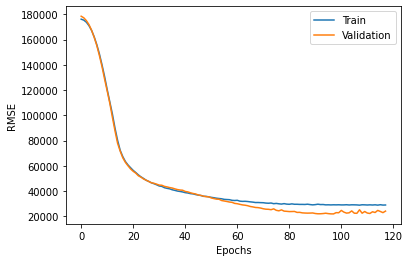

In [86]:
epochs = 200
learning_rate = 0.01
batch_size = 12


features_dict = {
    '04_08_MilNorm_Cullinan' : rr3.iloc[:,21].values,
    '09_11_MilNorm_Cullinan' : rr3.iloc[:,22].values,
    '12_14_MilNorm_Cullinan' : rr3.iloc[:,23].values,
    '15_17_MilNorm_Cullinan' : rr3.iloc[:,24].values,
    '18_19_MilNorm_Cullinan' : rr3.iloc[:,25].values,
    '20_21_MilNorm_Cullinan' : rr3.iloc[:,26].values,
    '04_08_MilNorm_Ghost' : rr3.iloc[:,27].values,
    '09_11_MilNorm_Ghost' : rr3.iloc[:,28].values,
    '12_14_MilNorm_Ghost' : rr3.iloc[:,29].values,
    '15_17_MilNorm_Ghost' : rr3.iloc[:,30].values,
    '18_19_MilNorm_Ghost' : rr3.iloc[:,31].values,
    '20_21_MilNorm_Ghost' : rr3.iloc[:,32].values,
    '04_08_MilNorm_Dawn' : rr3.iloc[:,33].values,
    '09_11_MilNorm_Dawn' : rr3.iloc[:,34].values,
    '12_14_MilNorm_Dawn' : rr3.iloc[:,35].values,
    '15_17_MilNorm_Dawn' : rr3.iloc[:,36].values,
    '18_19_MilNorm_Dawn' : rr3.iloc[:,37].values,
    '20_21_MilNorm_Dawn' : rr3.iloc[:,38].values,
    '04_08_MilNorm_Phantom' : rr3.iloc[:,39].values,
    '09_11_MilNorm_Phantom' : rr3.iloc[:,40].values,
    '12_14_MilNorm_Phantom' : rr3.iloc[:,41].values,
    '15_17_MilNorm_Phantom' : rr3.iloc[:,42].values,
    '18_19_MilNorm_Phantom' : rr3.iloc[:,43].values,
    '20_21_MilNorm_Phantom' : rr3.iloc[:,44].values  
}

test_features_dict = {
    '04_08_MilNorm_Cullinan' : rr3_test.iloc[:,21].values,
    '09_11_MilNorm_Cullinan' : rr3_test.iloc[:,22].values,
    '12_14_MilNorm_Cullinan' : rr3_test.iloc[:,23].values,
    '15_17_MilNorm_Cullinan' : rr3_test.iloc[:,24].values,
    '18_19_MilNorm_Cullinan' : rr3_test.iloc[:,25].values,
    '20_21_MilNorm_Cullinan' : rr3_test.iloc[:,26].values,
    '04_08_MilNorm_Ghost' : rr3_test.iloc[:,27].values,
    '09_11_MilNorm_Ghost' : rr3_test.iloc[:,28].values,
    '12_14_MilNorm_Ghost' : rr3_test.iloc[:,29].values,
    '15_17_MilNorm_Ghost' : rr3_test.iloc[:,30].values,
    '18_19_MilNorm_Ghost' : rr3_test.iloc[:,31].values,
    '20_21_MilNorm_Ghost' : rr3_test.iloc[:,32].values,
    '04_08_MilNorm_Dawn' : rr3_test.iloc[:,33].values,
    '09_11_MilNorm_Dawn' : rr3_test.iloc[:,34].values,
    '12_14_MilNorm_Dawn' : rr3_test.iloc[:,35].values,
    '15_17_MilNorm_Dawn' : rr3_test.iloc[:,36].values,
    '18_19_MilNorm_Dawn' : rr3_test.iloc[:,37].values,
    '20_21_MilNorm_Dawn' : rr3_test.iloc[:,38].values,
    '04_08_MilNorm_Phantom' : rr3_test.iloc[:,39].values,
    '09_11_MilNorm_Phantom' : rr3_test.iloc[:,40].values,
    '12_14_MilNorm_Phantom' : rr3_test.iloc[:,41].values,
    '15_17_MilNorm_Phantom' : rr3_test.iloc[:,42].values,
    '18_19_MilNorm_Phantom' : rr3_test.iloc[:,43].values,
    '20_21_MilNorm_Phantom' : rr3_test.iloc[:,44].values
}

n_cols = len(features_dict)

model = create_model_cross(0.01, feature_layer, n_cols=n_cols)

epochs, train_rmse, val_rmse = train_model(model, features_dict, train_labels, epochs=epochs, batch_size=batch_size)

plot_loss_curve(epochs, train_rmse, val_rmse)

In [87]:
test_rmse_Model_YearBinned_MileageNorm = model.evaluate(test_features_dict, test_labels, batch_size=batch_size, verbose=0)[1]
print('Test RMSE with Model_Cat, Year_Binned, Mileage_Norm: {:.3f}'.format(test_rmse_Model_YearBinned_MileageNorm))

Test RMSE with Model_Cat, Year_Binned, Mileage_Norm: 47876.781


In [88]:
# Normalize Year with Z_transformation
# Convert Cross Features into cross_features using feature_column
# Add dropouts to above models
# One-Hot Encode Years vs Normalize Years? Which works better?
# Use Binning on Year, Mileage, Use Original Year, and Product of Original Year with Year_Binned - Do same for Mileage and Linear Regression

In [126]:
rr3.head()

,Year,Mileage,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021,Mileage_Norm,2015_2017_Mileage_Norm,2004_2008_Mileage_Norm,2009_2011_Mileage_Norm,2012_2014_Mileage_Norm,2018_2019_Mileage_Norm,2020_2021_Mileage_Norm,04_08_MilNorm_Cullinan,09_11_MilNorm_Cullinan,12_14_MilNorm_Cullinan,15_17_MilNorm_Cullinan,18_19_MilNorm_Cullinan,20_21_MilNorm_Cullinan,04_08_MilNorm_Ghost,09_11_MilNorm_Ghost,12_14_MilNorm_Ghost,15_17_MilNorm_Ghost,18_19_MilNorm_Ghost,20_21_MilNorm_Ghost,04_08_MilNorm_Dawn,09_11_MilNorm_Dawn,12_14_MilNorm_Dawn,15_17_MilNorm_Dawn,18_19_MilNorm_Dawn,20_21_MilNorm_Dawn,04_08_MilNorm_Phantom,09_11_MilNorm_Phantom,12_14_MilNorm_Phantom,15_17_MilNorm_Phantom,18_19_MilNorm_Phantom,20_21_MilNorm_Phantom
90,2012,24000,0,0,1,0,1,0,0,1,0,0,0,0,-0.078165,-0.0,-0.0,-0.078165,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.078165,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
153,2019,8000,1,0,0,0,1,0,0,0,0,0,1,0,-0.650551,-0.0,-0.0,-0.000000,-0.000000,-0.650551,-0.0,-0.0,-0.0,-0.0,-0.0,-0.650551,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
113,2012,34509,0,0,1,0,1,0,0,1,0,0,0,0,0.297786,0.0,0.0,0.297786,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.297786,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,2018,2100,0,0,1,0,1,0,0,0,0,0,1,0,-0.861618,-0.0,-0.0,-0.000000,-0.000000,-0.861618,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.861618,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
130,2013,15218,0,0,1,0,1,0,0,0,1,0,0,0,-0.392333,-0.0,-0.0,-0.000000,-0.392333,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.392333,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [142]:
cols_to_drop = ['04_08_MilNorm_Cullinan', '09_11_MilNorm_Cullinan',
       '12_14_MilNorm_Cullinan', '15_17_MilNorm_Cullinan',
       '18_19_MilNorm_Cullinan', '20_21_MilNorm_Cullinan',
       '04_08_MilNorm_Ghost', '09_11_MilNorm_Ghost', '12_14_MilNorm_Ghost',
       '15_17_MilNorm_Ghost', '18_19_MilNorm_Ghost', '20_21_MilNorm_Ghost',
       '04_08_MilNorm_Dawn', '09_11_MilNorm_Dawn', '12_14_MilNorm_Dawn',
       '15_17_MilNorm_Dawn', '18_19_MilNorm_Dawn', '20_21_MilNorm_Dawn',
       '04_08_MilNorm_Phantom', '09_11_MilNorm_Phantom',
       '12_14_MilNorm_Phantom', '15_17_MilNorm_Phantom',
       '18_19_MilNorm_Phantom', '20_21_MilNorm_Phantom']

rr3.drop(labels=cols_to_drop, axis=1, inplace=True)

## **Functional API Modeling in Keras and TensorFlow**

While sing Functional_API, we can use Dropout to minimize overfitting by randomnly setting weights of features to 0 in nodes while training.

## **Modelling in Scikit Learn**

In [89]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

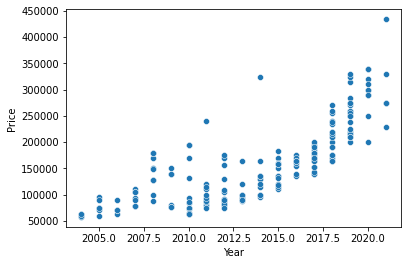

In [90]:
# Only including Models after 2004

sns.scatterplot(x=rr2['Year'], y=rr2['Price'])
plt.show()

In [91]:
rr2_train.shape

(154, 15)

### Simple Model with Only Year Mileage

In [92]:
sci_0 = rr.drop(['Unnamed: 0', 'Brand'], axis=1)
sci_0 = sci_0[sci_0['Year'] >= 2004]

sci_0_labels = sci_0.pop('Price')
sci_0_features = sci_0[['Mileage', 'Year']]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(sci_0_features, sci_0_labels, test_size=0.25, random_state=0, shuffle=True)

In [94]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

linreg.score(X_test, y_test)

0.5395236220689275

In [95]:
print('RMSE_Test with Year, Mileage Non_Normalized : {:.2f}'.format(mean_squared_error(y_test, y_pred, squared=False)))

RMSE_Test with Year, Mileage Non_Normalized : 49013.78


### Simple LinReg Model with OneHot_Encoding

In [96]:
sci_0 = rr.drop(['Unnamed: 0', 'Brand'], axis=1)

In [97]:
sci_0 = sci_0[sci_0['Year'] >= 2004]

In [98]:
sci_0_labels = sci_0.pop('Price')
sci_0_features = sci_0

In [99]:
sci_0_features = pd.get_dummies(sci_0_features, columns=['Model', 'Seller_Type'])

In [100]:
sci_0_features.head()

,Year,Mileage,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual
0,2007,38000,0,0,0,1,1,0
1,2006,56500,0,0,0,1,0,1
2,2015,6324,0,0,0,1,1,0
3,2009,21000,0,0,0,1,1,0
4,2004,107000,0,0,0,1,0,1


In [101]:
X_train, X_test, y_train, y_test = train_test_split(sci_0_features, sci_0_labels, test_size=0.25, random_state=0, shuffle=True)

In [102]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

linreg.score(X_test, y_test)

0.7504237616865568

In [103]:
print('RMSE_Test with Only OneHot_Encoding : {:.2f}'.format(mean_squared_error(y_test, y_pred, squared=False)))

RMSE_Test with Only OneHot_Encoding : 36084.12


In [104]:
# # train-test arrays

# train_features = rr2_train.values
# train_labels = train_label.values

# test_features = rr2_test.values
# test_labels = test_label.values

### Simple Model with Binned_Year & One-Hot Encoding - Linear Regression

In [105]:
rr2.head()

,Year,Mileage,Price,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021
202,2019,3200,219995,0,1,0,0,1,0,0,0,0,0,1,0
116,2013,17500,87500,0,0,1,0,1,0,0,0,1,0,0,0
104,2017,17494,139890,0,0,1,0,1,0,0,0,0,1,0,0
46,2007,14000,93000,0,0,0,1,1,0,1,0,0,0,0,0
26,2004,73000,63950,0,0,0,1,0,1,1,0,0,0,0,0


In [106]:
sci_1 = rr2.copy()

In [107]:
sci_1.values

array([[  2019,   3200, 219995, ...,      0,      1,      0],
       [  2013,  17500,  87500, ...,      0,      0,      0],
       [  2017,  17494, 139890, ...,      1,      0,      0],
       ...,
       [  2007,  53000, 105000, ...,      0,      0,      0],
       [  2018,   7300, 175000, ...,      0,      1,      0],
       [  2017,  22700, 152990, ...,      1,      0,      0]])

In [108]:
labels = sci_1.pop('Price')
features = sci_1

In [109]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state=0, shuffle=True)

In [110]:
X_train.shape

(153, 14)

In [111]:
X_test.shape

(52, 14)

In [112]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

linreg.score(X_test, y_test)

0.8623314182713853

In [113]:
from sklearn.metrics import mean_squared_error

y_pred = linreg.predict(X_test)

print('RMSE_Test with Binning & OneHot_Encoding: {:.2f}'.format(mean_squared_error(y_test, y_pred, squared=False)))

RMSE_Test with Binning & OneHot_Encoding: 29991.20


### Z_score Normalizing, One-Hot Encoded, Binned

In [114]:
features['Mileage_Norm'] = (features['Mileage'] - features['Mileage'].mean())/features['Mileage'].std()
features['Year_Norm'] = (features['Year'] - features['Year'].mean())/features['Year'].std()

In [115]:
features.head()

,Year,Mileage,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021,Mileage_Norm,Year_Norm
202,2019,3200,0,1,0,0,1,0,0,0,0,0,1,0,-0.842342,1.132099
116,2013,17500,0,0,1,0,1,0,0,0,1,0,0,0,-0.303779,-0.180325
104,2017,17494,0,0,1,0,1,0,0,0,0,1,0,0,-0.304005,0.694624
46,2007,14000,0,0,0,1,1,0,1,0,0,0,0,0,-0.435595,-1.492749
26,2004,73000,0,0,0,1,0,1,1,0,0,0,0,0,1.786449,-2.148961


In [116]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=0, shuffle=True)

In [117]:
print('No. of Features Used : {}'.format(X_train.shape[1]))

No. of Features Used : 16


In [118]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

linreg.score(X_test, y_test)

0.8623314182713806

In [119]:
print('RMSE_Test with Encoding & Normalization: {:.2f}'.format(mean_squared_error(y_test, y_pred, squared=False)))

RMSE_Test with Encoding & Normalization: 29991.20


### Normalization, OneHot_Encoding, Binning & Cross_Features

In [120]:
features['MileNorm_YearNorm'] = features['Mileage_Norm']*features['Year_Norm']
features['04_08_MilNorm'] = features['Year_Binned_2004_2008'] * features['Mileage_Norm']
features['09_11_MilNorm'] = features['Year_Binned_2009_2011'] * features['Mileage_Norm']
features['12_14_MilNorm'] = features['Year_Binned_2012_2014'] * features['Mileage_Norm']
features['15_17_MilNorm'] = features['Year_Binned_2015_2017'] * features['Mileage_Norm']
features['18_19_MilNorm'] = features['Year_Binned_2018_2019'] * features['Mileage_Norm']
features['20_21_MilNorm'] = features['Year_Binned_2020_2021'] * features['Mileage_Norm']

In [121]:
features.head()

,Year,Mileage,Model_Cullinan,Model_Dawn,Model_Ghost,Model_Phantom,Seller_Type_Dealer,Seller_Type_Individual,Year_Binned_2004_2008,Year_Binned_2009_2011,Year_Binned_2012_2014,Year_Binned_2015_2017,Year_Binned_2018_2019,Year_Binned_2020_2021,Mileage_Norm,Year_Norm,MileNorm_YearNorm,04_08_MilNorm,09_11_MilNorm,12_14_MilNorm,15_17_MilNorm,18_19_MilNorm,20_21_MilNorm
202,2019,3200,0,1,0,0,1,0,0,0,0,0,1,0,-0.842342,1.132099,-0.953615,-0.000000,-0.0,-0.000000,-0.000000,-0.842342,-0.0
116,2013,17500,0,0,1,0,1,0,0,0,1,0,0,0,-0.303779,-0.180325,0.054779,-0.000000,-0.0,-0.303779,-0.000000,-0.000000,-0.0
104,2017,17494,0,0,1,0,1,0,0,0,0,1,0,0,-0.304005,0.694624,-0.211169,-0.000000,-0.0,-0.000000,-0.304005,-0.000000,-0.0
46,2007,14000,0,0,0,1,1,0,1,0,0,0,0,0,-0.435595,-1.492749,0.650234,-0.435595,-0.0,-0.000000,-0.000000,-0.000000,-0.0
26,2004,73000,0,0,0,1,0,1,1,0,0,0,0,0,1.786449,-2.148961,-3.839008,1.786449,0.0,0.000000,0.000000,0.000000,0.0


In [122]:
print('No. of features Used: {}'.format(features.shape[1]))

No. of features Used: 23


In [123]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0, shuffle=True, test_size=0.25)

In [124]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

linreg.score(X_test, y_test)

0.8640669325693416

In [125]:
print('RMSE_Test with Feature_Cross, Binning, Normalization, Encoding: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))

RMSE_Test with Feature_Cross, Binning, Normalization, Encoding: 29801.561195518345


**Use of Lasso Regression**

In [159]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1)

lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

lasso.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46073440879.69715, tolerance: 80440932.29100001
  positive)


0.8642957118086778

In [161]:
np.sqrt(mean_squared_error(y_test, y_pred))

29776.472194879767

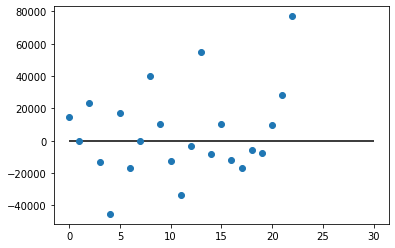

In [172]:
plt.plot(lasso.coef_, marker='o', linestyle='none')
plt.hlines(y=0, xmin=0, xmax=30)

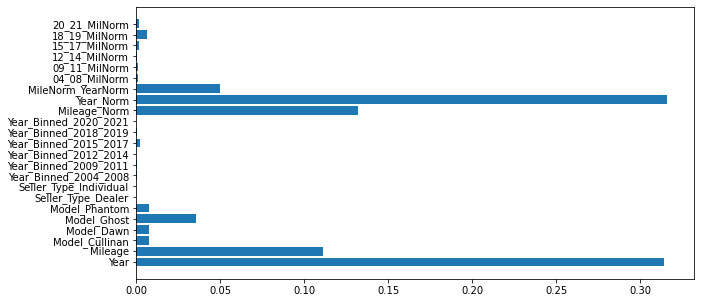

In [229]:
plt.figure(figsize=(10,5))
plt.barh(X_train.columns,rf.feature_importances_)
plt.show()

In [232]:
X_train.columns[rf.feature_importances_ > 0.05]

Index(['Year', 'Mileage', 'Mileage_Norm', 'Year_Norm'], dtype='object')

In [174]:
alpha = [0.01, 0.1, 1, 10]

rmses = []
r2s = []

for a in alpha:
  lasso = Lasso(alpha=a)
  lasso.fit(X_train, y_train)
  y_pred = lasso.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  score = lasso.score(X_test, y_test)
  rmses.append(rmse)
  r2s.append(score)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46101191422.44517, tolerance: 80440932.29100001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46084842679.215065, tolerance: 80440932.29100001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46073440879.69715, tolerance: 80440932.29100001
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46611980313

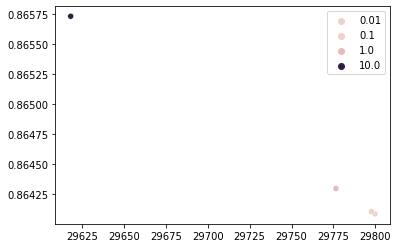

In [185]:
sns.scatterplot(x=rmses, y=r2s, hue=alpha)
plt.show()

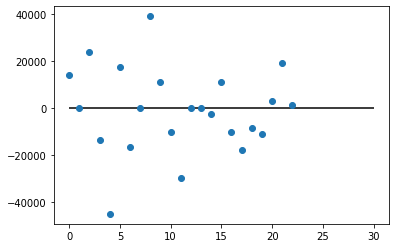

In [183]:
plt.plot(lasso.coef_, marker='o', linestyle='none')
plt.hlines(y=0, xmin=0, xmax=30)

**RandomForest Ensemble**

In [218]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=5, oob_score=True, max_depth=20, max_features='auto')

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf.score(X_test, y_test)

0.8465092484024367

In [219]:
np.sqrt(mean_squared_error(y_test, y_pred))

31667.77594290306

In [220]:
# estimators = list(np.linspace(100, 1000, 10, dtype='int'))
rf.oob_score_

0.8146269128375936

**XGBoost**

In [223]:
from xgboost import XGBRFRegressor

xgbrf = XGBRFRegressor()

xgbrf.fit(X_train, y_train)

y_pred = xgbrf.predict(X_test)

xgbrf.score(X_test, y_test)

[11:58:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.7081143254802561

In [224]:
np.sqrt(mean_squared_error(y_test, y_pred))

43669.96537289258

**Hyperparameter Tuning**

In [202]:
xgbrf.get_xgb_params

<bound method XGBRFRegressor.get_xgb_params of XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.8, verbosity=1)>

In [203]:
xgbrf.get_params

<bound method XGBModel.get_params of XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.8, verbosity=1)>

In [209]:
param = {
    'learning_rate' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'max_depth' : [3, 5, 10, 20],
    'n_estimators' : [150, 300, 600, 1200],
    'reg_alpha' : [0.01, 0.1, 0.5, 1],
}

from sklearn.model_selection import RandomizedSearchCV

xgbrf = XGBRFRegressor()

rand = RandomizedSearchCV(xgbrf, param, cv = 3, scoring='neg_root_mean_squared_error', verbose=0)

rand.fit(X_train, y_train)

y_pred = rand.predict(X_test)

rand.score(X_test, y_test)

[11:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

-42743.5214018317

In [210]:
np.sqrt(mean_squared_error(y_test, y_pred))

42743.5214018317